# 📊 Part II: Conformal Classification

The objective is to use conformal prediction to assess the uncertainty associated with a predictive classifier. We will assume that this classifier is already deployed in production from PUNCC's perspective. Our task is to perform post-hoc calibration to enable the generation of reliable prediction intervals.

<div align=center>
<img src="assets/classification_demo.svg" width="800"> </img>
</div>

**Links**
- [<img src="https://github.githubassets.com/images/icons/emoji/octocat.png" width=20> Github](https://github.com/deel-ai/puncc)
- [📘 Documentation](https://deel-ai.github.io/puncc/index.html)

### ⚙️ Setup  <a class="anchor" id="cr-setup"></a>

🐾 Ensure we have puncc installed. You can install it if needed using pip:

In [1]:
!pip install puncc

You should consider upgrading via the 'C:\Users\mouhcine.mendil\Documents\Projets\puncc\puncc-dev-env\Scripts\python.exe -m pip install --upgrade pip' command.


We import some modules:

In [2]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# Set seaborn theme
sns.set_theme()

# Ignore warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
tf.random.set_seed(0)
tf.keras.utils.set_random_seed(0)

### 💾 MNIST Dataset <a class="anchor" id="cc-data"></a>

MNIST dataset contains a large number of $28\times28$ digit images to which are associated digit labels. As the data generating process is considered i.i.d (check [this post](https://newsletter.altdeep.ai/p/the-story-of-mnist-and-the-perils)), conformal prediction is applicable 👏.

We have two available data subsets:

* Calibration subset ${\cal D_{calib}}$ on which nonconformity scores are computed.
* New data subset ${\cal D_{new}}$ on which the prediction set are estimated.

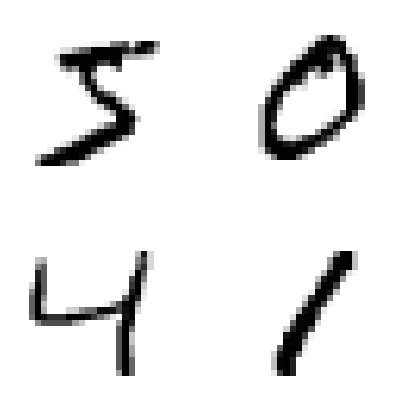

In [3]:
# Load MNIST Database
(X_train_mnist, y_train_mnist), (X_new_mnist, y_new_mnist) = (
    tf.keras.datasets.mnist.load_data()
)

# Preprocessing: reshaping and standardization
X_train_mnist = X_train_mnist.reshape((len(X_train_mnist), 28, 28))
X_train_mnist = X_train_mnist.astype("float32") / 255
X_new_mnist = X_new_mnist.reshape((len(X_new_mnist), 28, 28))
X_new_mnist = X_new_mnist.astype("float32") / 255

# Split fit and calib datasets
X_fit_mnist = X_train_mnist[:50000]
y_fit_mnist = y_train_mnist[:50000]

# Calibration data
X_calib_mnist = X_train_mnist[50000:]
y_calib_mnist = y_train_mnist[50000:]

# One hot encoding of classes
y_fit_cat = tf.keras.utils.to_categorical(y_fit_mnist)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
ax = ax.flatten()

for i in range(4):
    ax[i].imshow(1 - X_fit_mnist[i], cmap="gray")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

### 🔮 Prediction model <a class="anchor" id="cc-pm"></a>

We will consider a convolutional neural network (convnet) defined below. The model will be trained prior to any conformalization and will be assumed to be in production from this point on.

In [ ]:
# Classification model: convnet composed of two convolution/pooling layers
# and a dense output layer
convnet_model = tf.keras.models.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

convnet_model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = convnet_model.fit(
    X_fit_mnist,
    y_fit_cat,
    epochs=1,
    batch_size=512,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/2
176/176 [==============================] - 9s 48ms/step - loss: 0.5743 - accuracy: 0.8408 - val_loss: 0.2544 - val_accuracy: 0.9256
Epoch 2/2
176/176 [==============================] - 9s 54ms/step - loss: 0.1922 - accuracy: 0.9420 - val_loss: 0.1579 - val_accuracy: 0.9520


### ⚖️ Naive Approach <a class="anchor" id="cc-calib"></a>

Our convnet has softmax function applied to logit outputs, to normalize them and convert them into probabilities. One may attempt to use logit scores to meet requirements on error rate $\le \alpha = 0.05$.

<div align=center>
<img src="assets/naive_classification.svg" width="600"> </img>
</div>

These logits can be used to determine the class with the highest score, but they do not necessarily represent well-calibrated probabilities.


<div align=center>
<img src="assets/fooling_dnns.png" width="800"> </img>
</div>

We can't trust logit scores to reliably estimate uncertainty. 

### ⚙️ Conformal Prediction <a class="anchor" id="cc-cp"></a>

The goal is provide a reliable uncertainty evaluation through conformal prediction associated with our pretrained convnet classifier.

The APS procedure is the chosen method.

<div align=center>
<img src="assets/workflow_classification.svg" width="800"> </img>
</div>

#### 1. Instantiation

In [5]:
from deel.puncc.classification import APS

# Instanciate the APS wrapper around the convnet predictor.
# The `train` argument is set to False as the model is already trained

convnet_cp = APS(convnet_model, train=False)

#### 2. Calibration

In [6]:
# Compute the nonconformity scores on the calibration dataset
convnet_cp.fit(X_calib=X_calib_mnist, y_calib=y_calib_mnist)

313/313 [==============================] - 1s 4ms/step


#### 3. Conformal Inference

In [7]:
# Use chooses the coverage target 1-alpha = 95%
alpha = 0.05

# The `predict` returns the output of the convnet model `y_pred` and
# the calibrated prediction set `set_pred`.
y_pred, set_pred = convnet_cp.predict(X_new_mnist, alpha=alpha)

313/313 [==============================] - 1s 3ms/step


Let's visualize an example of point prediction and set prediction.

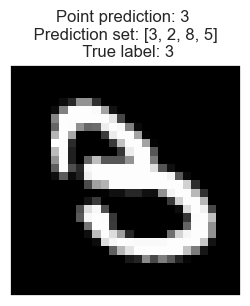

In [ ]:
sample = 18

# sort y_pred[sample] in reversed order
ranked_pred = y_pred[sample].argsort()[::-1]

# Plot results
fig = plt.figure(figsize=(3, 3))
plt.imshow(X_new_mnist[sample].reshape((28, 28)), cmap="gray")
_ = plt.title(
    f"Point prediction: {np.argmax(y_pred[sample])} \n "
    + f"Prediction set: {[int(v) for v in set_pred[sample]]} \n True label: {y_new_mnist[sample]}"
)

_ = plt.xticks([])
_ = plt.yticks([])

Puncc provides several metrics in `deel.puncc.metrics` to evaluate the conformalization procedure. Below, we compute the average empirical coverage and the average empirical size of the prediction sets on the new examples:

In [9]:
from deel.puncc import metrics

mean_coverage = metrics.classification_mean_coverage(y_new_mnist, set_pred)
mean_size = metrics.classification_mean_size(set_pred)

print(f"Empirical coverage : {mean_coverage:.2f}")
print(f"Average set size : {mean_size:.2f}")

Empirical coverage : 0.95
Average set size : 1.18


We can check the calibrated threshold selected by the algorithm (quantile of nonconformity scores) and conclude. 

In [10]:
# Get nonconformity scores
nonconf_scores = convnet_cp.conformal_predictor.get_nonconformity_scores()[0]

# Size of the calibration set
n = len(nonconf_scores)

# Compute the calibrated treshold
calibrated_treshold = np.quantile(
    nonconf_scores, (1 - alpha) * (n + 1) / n, method="inverted_cdf"
)

In [11]:
print(f"Uncalibrated treshold : {1-alpha:.2f}")
print(f"Calibrated treshold : {calibrated_treshold:.2f}")

Uncalibrated treshold : 0.95
Calibrated treshold : 0.94
